In [1]:
from optyx.qpath import *
from optyx.circuit import Phase
from sympy.abc import theta

In [2]:
circuit = Create(2, 0) >> BS >> (Phase(theta) @ Id(1)) >> BS

In [3]:
num_op = Split() >> (Select() >> Create()) @ Id(1) >> Merge()
observable = num_op @ Id(1)

In [4]:
expectation = circuit >> observable >> circuit.dagger()

In [5]:
def to_float(x):
    if isinstance(x, complex):
        assert x.imag < 1e-10
        return x.real
    return x
free_syms = [theta]
f = lambda x: to_float(expectation.lambdify(theta)(x).eval().array[0, 0])
df = lambda x: to_float(expectation.grad(theta).lambdify(theta)(x).eval().array[0, 0])

In [6]:
from tqdm import tqdm
xs = []
fxs = []
dfxs = []

def optimize(x0):
    x = x0

    for _ in tqdm(range(20)):
        fx = f(x)
        dfx = df(x)
        xs.append(x)
        fxs.append(fx)
        dfxs.append(dfx)
        print(x, fx, dfx)
        x = to_float(x - 0.01 * dfx)
    xs.append(x)
    fxs.append(f(x))
    dfxs.append(df(x))

In [7]:
optimize(0.15)

 25%|█████████████████████████████████▌                                                                                                    | 5/20 [00:00<00:00, 23.28it/s]

0.15 0.4122147477075271 5.0832036923152675
0.09916796307684732 0.187921226419906 3.6665391278204957
0.06250257179864235 0.0761266514243794 2.4045647212120294
0.03845692458652206 0.02905124526110993 1.5034878094169355
0.023422046492352702 0.010809247572275622 0.9213312800351796
0.014208733692000906 0.003982465470418035 0.5601934852676808


 55%|█████████████████████████████████████████████████████████████████████████▏                                                           | 11/20 [00:00<00:00, 24.79it/s]

0.008606798839324099 0.0014618647855456138 0.33961721050420013
0.005210626734282097 0.0005358841049065132 0.20567055179305355
0.0031539212163515617 0.00019634380812596163 0.12450366972213929
0.0019088845191301688 7.192565848796218e-05 0.07535793342973734
0.0011553051848327953 2.6346399858670543e-05 0.04560921999683797
0.0006992129848644156 9.65045993892725e-06 0.027603733414283793


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17/20 [00:00<00:00, 25.32it/s]

0.0004231756507215776 3.5348486747584737e-06 0.016706285374424226
0.0002561127969773353 1.2947687396212068e-06 0.010110923589119906
0.00015500356108613626 4.7425624507323087e-07 0.0061192943473497175
9.381061761263909e-05 1.7371355931130428e-07 0.003703494523384995
5.677567237878914e-05 6.362888438528418e-08 0.002241413656398377
3.436153581480537e-05 2.3306382663939122e-08 0.0013565390498845751


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.61it/s]

2.079614531595962e-05 8.536806299338615e-09 0.0008209989070087971
1.2586156245871648e-05 3.126914299030046e-09 0.0004968815317908841


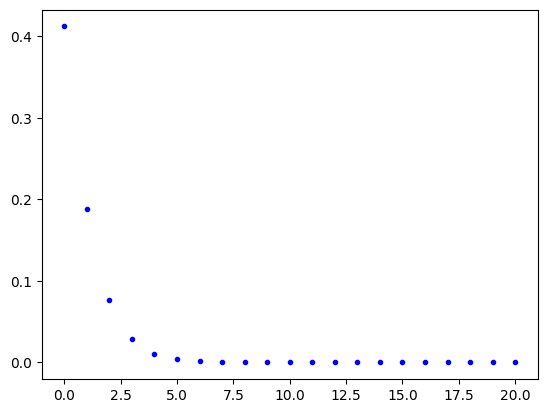

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(xs)),fxs,'b.')
plt.show()